# Orange Juice Data Exploration in Python

In this notebook, we use Python to explore the Orange Juice dataset in R package `bayesm`. This dataset is used in the retail forecasting benchmark [OrangeJuice_Pt_3Weeks_Weekly](https://msdata.visualstudio.com/AlgorithmsAndDataScience/_git/TSPerf?path=%2Fretail_sales%2FOrangeJuice_Pt_3Weeks_Weekly&version=GBmaster) of TSPerf. 

To run this notebook, please first create and activate `tsperf` conda environment by running the following commands from `TSPerf` directory: 

`conda env create --file ./common/conda_dependencies.yml`  
`conda activate tsperf`  

Then, inside the `tsperf` environment, please run the following commands to create the jupyter notebook kernel:

``
python -m ipykernel install --name tsperf_python
``

Finally, you can launch the Jupyter notebook by running `jupyter notebook` and select the kernel named `tsperf_python` in the list of kernels under Kernel tab.

In [1]:
# import packages
import pandas as pd
import numpy as np
import os
import math
import itertools
import matplotlib.pyplot as plt

In [2]:
# read in the data
data_dir = '..\data'
sales_file = os.path.join(data_dir, 'yx.csv')
store_file = os.path.join(data_dir, 'storedemo.csv')
sales = pd.read_csv(sales_file, index_col=False)
storedemo = pd.read_csv(store_file, index_col=False)

# show first few rows of sales data
print('First few rows of sales data: \n')
print(sales.head(4))
print('\n')
# show first few rows of store demographic data
print('First few rows of store demographic data: \n')
print(storedemo.head(4))

First few rows of sales data: 

   store  brand  week   logmove  constant    price1    price2    price3  \
0      2      1    40  9.018695         1  0.060469  0.060497  0.042031   
1      2      1    46  8.723231         1  0.060469  0.060312  0.045156   
2      2      1    47  8.253228         1  0.060469  0.060312  0.045156   
3      2      1    48  8.987197         1  0.060469  0.060312  0.049844   

     price4    price5    price6    price7    price8    price9   price10  \
0  0.029531  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844   
1  0.046719  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031   
2  0.046719  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656   
3  0.037344  0.049531  0.053021  0.045781  0.041406  0.042344  0.032656   

    price11  deal  feat     profit  
0  0.038984     1   0.0  37.992326  
1  0.038984     0   0.0  30.126667  
2  0.038984     0   0.0  30.000000  
3  0.038984     0   0.0  29.950000  


First few rows of store demog

In [3]:
# Check number of time series and lengths
print('number of stores is {}.'.format(len(sales.groupby(['store']).groups.keys())))
print('number of brands is {}.'.format(len(sales.groupby(['brand']).groups.keys())))
print('number of time series is {}.'.format(len(sales.groupby(['store', 'brand']).groups.keys())))
print('lenth distribution of the time series:')
print(sales.groupby(['store', 'brand']).size().describe())

number of stores is 83.
number of brands is 11.
number of time series is 913.
lenth distribution of the time series:
count    913.000000
mean     116.253012
std        4.730982
min       87.000000
25%      115.000000
50%      117.000000
75%      119.000000
max      121.000000
dtype: float64


In [4]:
# Fill missing gaps 
store_list = sales['store'].unique()
brand_list = sales['brand'].unique()
week_list = range(sales['week'].min(), sales['week'].max() + 1)
item_list = list(itertools.product(store_list, brand_list, week_list))
item_df = pd.DataFrame.from_records(item_list, columns=['store', 'brand', 'week'])
print('Total number of rows before filling gaps is {}.'.format(len(sales)))
sales = item_df.merge(sales, how='left', on=['store', 'brand', 'week'])
print('Total number of rows after filling gaps is {}.'.format(len(sales)))
# fill the missing `logmove` with zeros
sales['logmove'] = sales['logmove'].fillna(value=0)
# Merge sales and store demographics
sales = sales.merge(storedemo, how='left', left_on='store', right_on='STORE')

Total number of rows before filling gaps is 106139.
Total number of rows after filling gaps is 110473.


In [5]:
# Compute unit sales
sales['move'] = sales['logmove'].apply(lambda x: round(math.exp(x)) if x > 0 else 0)

## Visualize sample time series

We look at some examples of weekly sales time series for sample store and brand.

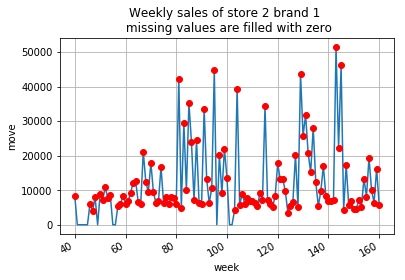

In [6]:
# Plot sample time series of sales
sample_store = 2
sample_brand = 1
sales_sub = sales.loc[(sales['store'] == sample_store) & (sales['brand'] == sample_brand)]
plt.plot(sales_sub['week'], sales_sub['move'])
plt.plot(sales_sub['week'].loc[sales_sub['move'] > 0], 
         sales_sub['move'].loc[sales_sub['move'] > 0], linestyle='', marker='o', color='red')
plt.gcf().autofmt_xdate()
plt.xlabel('week')
plt.ylabel('move')
plt.title('Weekly sales of store {} brand {} \n missing values are filled with zero'.format(sample_store, sample_brand))
plt.grid(True)
plt.show()

Weekly sales of all brands in store 2.


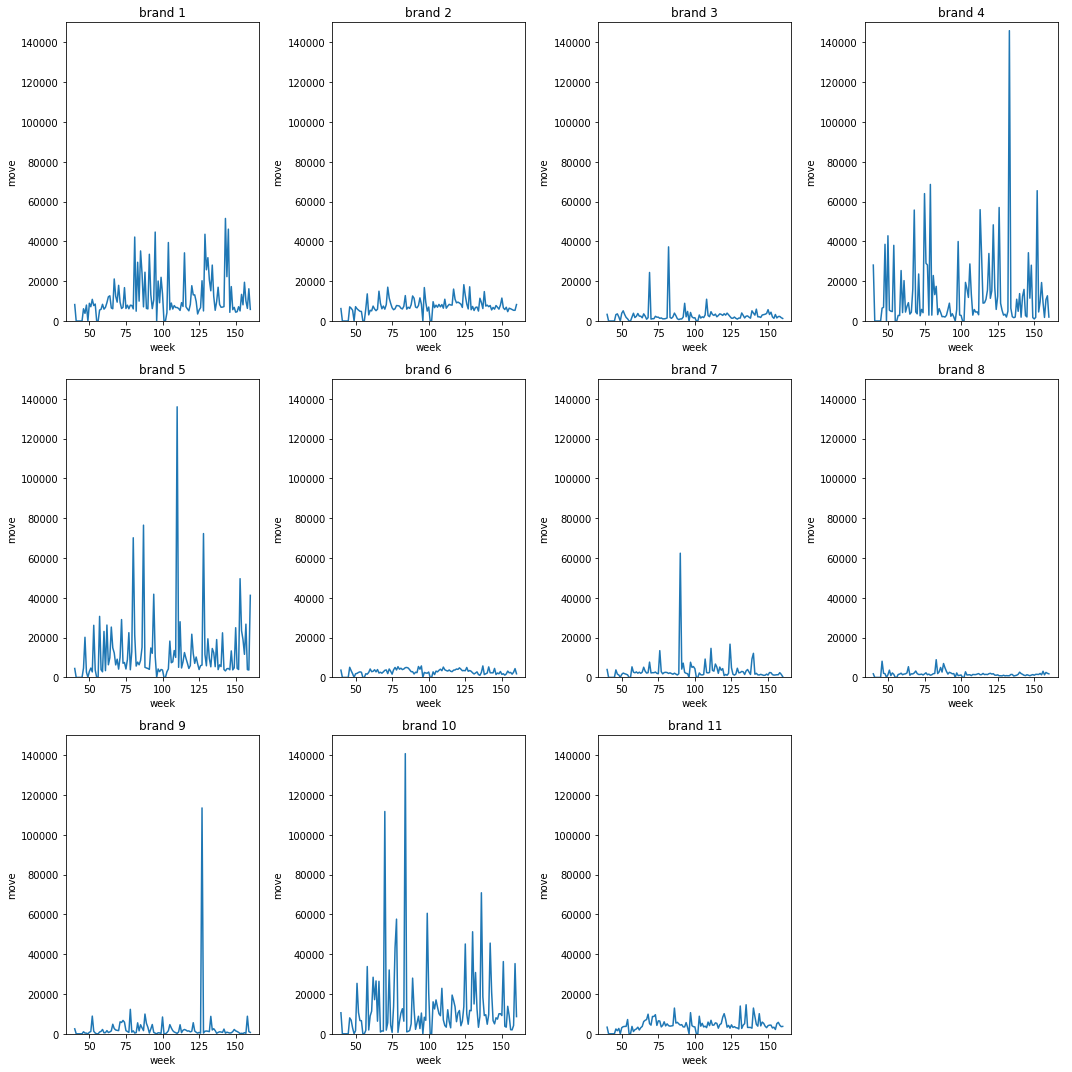

In [16]:
# Plot sales of all brands in a sample store
sample_store = 2
brand_list = sales.loc[(sales['store'] == sample_store), 'brand'].unique()
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,15))
print('Weekly sales of all brands in store {}.'.format(sample_store))

brand_num = 0
for row in axes:
    for col in row:
        if brand_num < len(brand_list):
            brand = brand_list[brand_num]
            sales_sub = sales.loc[(sales['store'] == sample_store) & (sales['brand'] == brand)]
            col.plot(sales_sub['week'], sales_sub['move'])
            col.set_ylim(0, 150000)
            col.set_title('brand {}'.format(brand))
            col.set_xlabel('week')
            col.set_ylabel('move')
            brand_num += 1
        else:
            col.axis('off')
plt.tight_layout()

## Impact of demographics, brand, and store

We find that the demographics seem to not have any noticable impact on the sales, while brand and store seem to have significant impact on sales.

In [38]:
print('Correlation between unit sales and each demographic feature:')
print(sales[storedemo.columns[1:]].corrwith(sales['move']))
print('\nCorrelation between log-scale sales and each demographic feature:')
print(sales[storedemo.columns[1:]].corrwith(sales['logmove']))

Correlation between unit sales and each demographic feature:
AGE60       0.047409
EDUC       -0.026599
ETHNIC      0.074581
INCOME     -0.050484
HHLARGE     0.000940
WORKWOM    -0.063461
HVAL150    -0.026362
SSTRDIST    0.032859
SSTRVOL    -0.027255
CPDIST5     0.006355
CPWVOL5    -0.078144
dtype: float64

Correlation between log-scale sales and each demographic feature:
AGE60       0.034674
EDUC       -0.012200
ETHNIC      0.044293
INCOME     -0.023183
HHLARGE    -0.026629
WORKWOM    -0.023059
HVAL150    -0.002460
SSTRDIST   -0.006033
SSTRVOL    -0.071799
CPDIST5     0.026050
CPWVOL5    -0.059456
dtype: float64


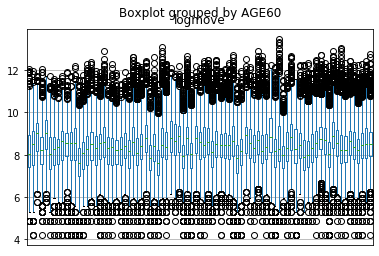

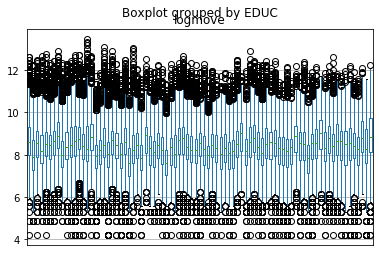

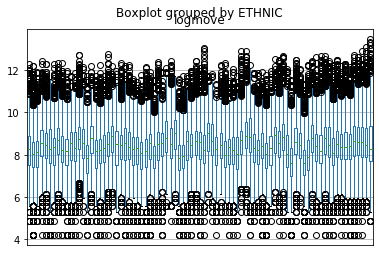

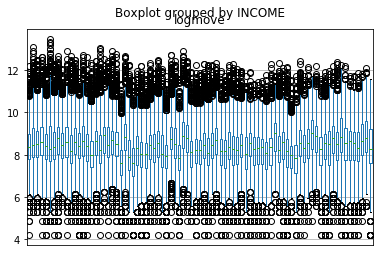

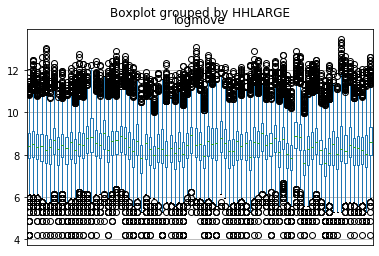

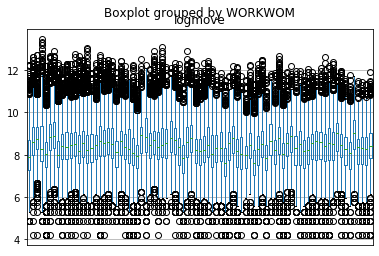

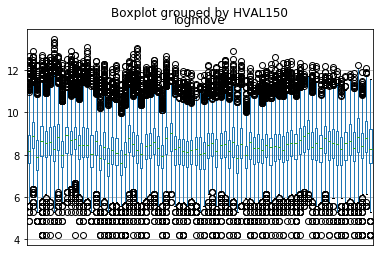

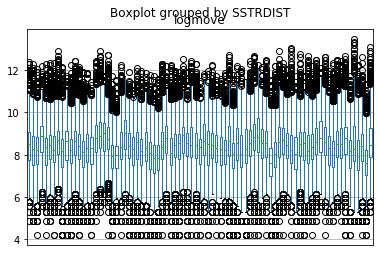

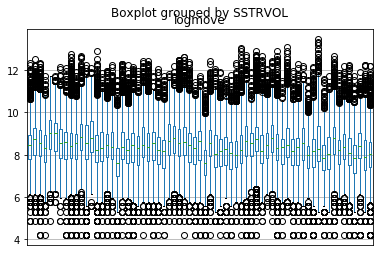

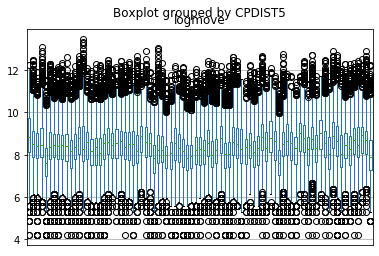

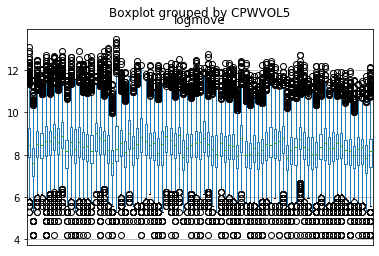

In [40]:
# Plot box plot of logmove vs. store demographic columns
for cl in storedemo.columns[1:]:
    p = sales.loc[sales['logmove'] != 0].boxplot(column='logmove', by=cl)
    p.axes.get_xaxis().set_visible(False)

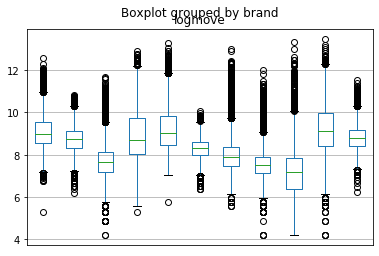

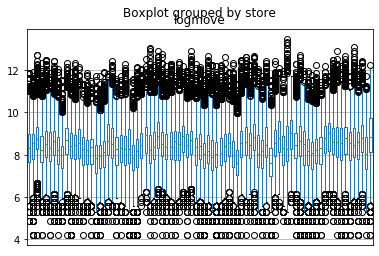

In [42]:
# Plot box plot of logmove across different brands and stores
for by_cl in ['brand', 'store']:
    p = sales.loc[sales['logmove'] != 0].boxplot(column='logmove', by=by_cl)
    p.axes.get_xaxis().set_visible(False)

## Check seasonality and autocorrelation

Overall, we don't find a strong seasonality in the data. It seems that there is a weak yearly-seasonality according to the seasonal-trend-level decomposition and the autocorrelation values around the lag of 52 weeks. As a rough estimate, autocorrelation beyond 20 weeks is usually very small. 

In [43]:
# autocorrealtion: weekly, monthly, quarterly, yearly
def single_autocorr(series, lag):
    """
    Autocorrelation for single data series
    :param series: traffic series
    :param lag: lag, days
    :return:
    """
    s1 = series[lag:]
    s2 = series[:-lag]
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0

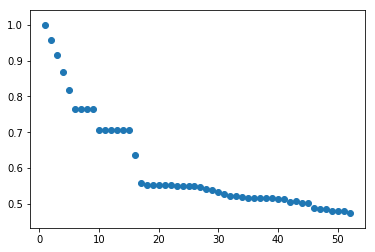

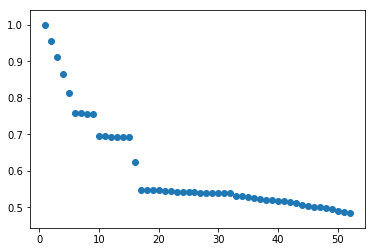

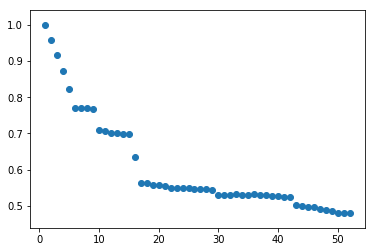

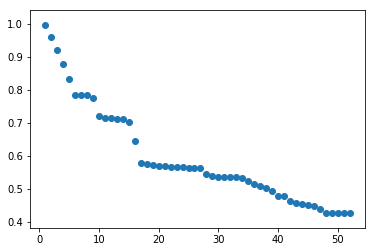

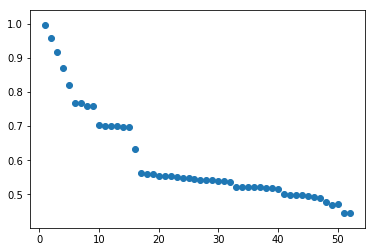

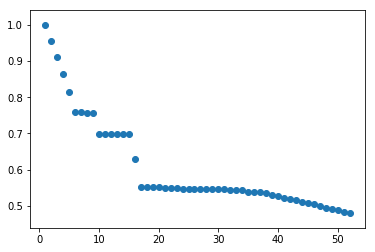

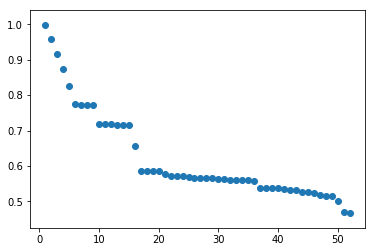

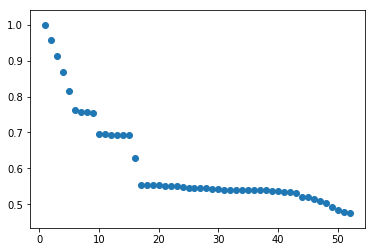

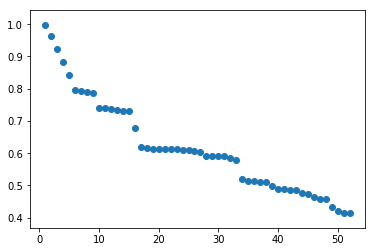

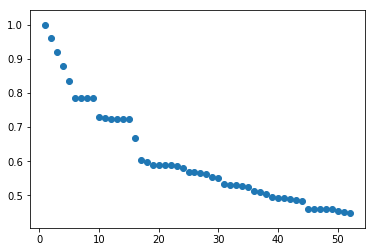

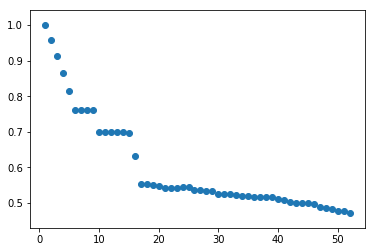

In [44]:
# monotonically decreasing, no strong seasonality pattern
max_store_limit = 1
store_list = sales['store'].unique()
brand_list = sales['brand'].unique()
l_range = range(1, 53)

for i in range(min(max_store_limit, len(store_list))):
    for j in range(len(brand_list)):
        store = store_list[i]
        brand = brand_list[j]
        d = sales.loc[(sales['store'] == store) & (sales['brand'] == brand)]
        cor = []
        for l in l_range:
            cor.append(single_autocorr(d['logmove'], l))
        plt.scatter(l_range, cor)
        plt.show()

In [10]:
for l in [13, 26, 39, 52]:
    print(l)
    print(sales.groupby(['store', 'brand']).apply(lambda x: single_autocorr(x['logmove'], l)).describe())

13
count    913.000000
mean       0.873807
std        0.047421
min        0.611930
25%        0.846118
50%        0.876367
75%        0.908974
max        0.982957
dtype: float64
26
count    913.000000
mean       0.709398
std        0.097350
min        0.245297
25%        0.663293
50%        0.721891
75%        0.771751
max        0.911748
dtype: float64
39
count    913.000000
mean       0.490408
std        0.127948
min        0.025220
25%        0.402703
50%        0.494810
75%        0.585219
max        0.822233
dtype: float64
52
count    913.000000
mean       0.160086
std        0.094159
min       -0.066287
25%        0.096271
50%        0.157706
75%        0.214962
max        0.525208
dtype: float64


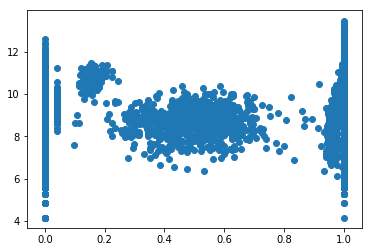

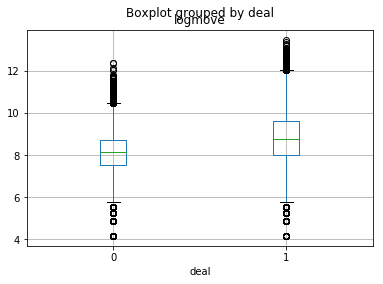

In [11]:
# correlation between deal, feat
plt.scatter(sales['feat'], sales['logmove'])
p = sales.boxplot(column='logmove', by='deal')

In [12]:
# correlation between the competitive prices
sales['price'] = sales.apply(lambda x: x.loc['price' + str(int(x.loc['brand']))], axis=1)
price_cols = ['price1', 'price2', 'price3', 'price4', 'price5', 'price6', 'price7', 'price8', 
                 'price9', 'price10', 'price11']
sales['avg_price'] = sales[price_cols].sum(axis=1).apply(lambda x: x / len(price_cols))
sales['price_ratio'] = sales.apply(lambda x: x['price'] / x['avg_price'], axis=1)

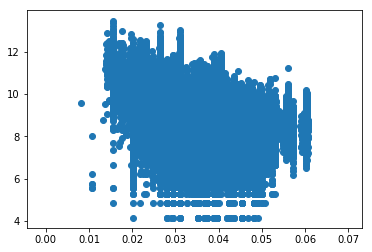

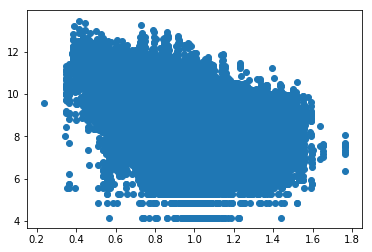

In [13]:
plt.scatter(sales['price'], sales['logmove'])
plt.show()
plt.scatter(sales['price_ratio'], sales['logmove'])
plt.show()

In [14]:
# read in the holiday information
week_decoder = pd.read_csv('week_decoder.csv', index_col=False)
sales = sales.merge(week_decoder, how='left', left_on='week', right_on='Week #')
sales['Start'] = pd.to_datetime(sales['Start'])
sales['End'] = pd.to_datetime(sales['End'])
sales['Special Events'] = sales['Special Events'].map(lambda x: x.strip())

In [15]:
print(sales['logmove'].describe())
sales.groupby(by='Special Events').apply(lambda x: x['logmove'].describe())

count    106139.000000
mean          8.417476
std           1.141371
min           4.158883
25%           7.699842
50%           8.392990
75%           9.049232
max          13.482016
Name: logmove, dtype: float64


logmove,count,mean,std,min,25%,50%,75%,max
Special Events,,,,,,,,
,88660.0,8.418506,1.134555,4.158883,7.714231,8.392990,9.041685,13.482016
4th of July,2475.0,8.282183,1.225836,4.158883,7.592870,8.302018,8.962904,11.859178
Christmas,1804.0,8.492180,1.177568,4.158883,7.714231,8.534640,9.284331,11.639875
Easter,1793.0,8.569481,1.435508,4.158883,7.624619,8.476371,9.300547,12.932577
Halloween,1793.0,8.296399,0.971076,4.158883,7.699842,8.184235,8.691483,11.578863
Labor Day,2574.0,8.389046,1.070722,4.158883,7.796469,8.378391,9.041685,11.417999
Memorial Day,1738.0,8.457200,1.077481,5.257495,7.655391,8.442446,9.176163,11.603716
New-Year,1749.0,8.542589,1.179606,5.545177,7.624619,8.601534,9.379239,11.638747
Presidents Day,1749.0,8.367503,1.324196,4.158883,7.491088,8.236421,8.929568,13.047916


In [30]:
def calc_deal_effect(df):
    return pd.Series(df.groupby(by='Special Events').apply(
        lambda x: x['logmove'].loc[x['deal'] == 1].median() / x['logmove'].loc[x['deal'] == 0].median()))

deal_effect = sales.groupby(['store', 'brand']).apply(lambda x: calc_deal_effect(x))
deal_effect = deal_effect.reset_index().rename(columns={0: 'deal_effect'})

In [35]:
tmp = deal_effect.groupby(by='Special Events').apply(
    lambda x: x['deal_effect'].loc[x['deal_effect'].notnull()].describe())
tmp.sort_values(by=['50%', '75%'])

deal_effect,count,mean,std,min,25%,50%,75%,max
Special Events,,,,,,,,
Thanksgiving,557.0,0.978489,0.098358,0.526671,0.952277,0.993408,1.036669,1.318398
Christmas,345.0,1.012900,0.095264,0.720987,0.951509,1.021780,1.068733,1.420975
Halloween,571.0,1.056156,0.126715,0.614449,0.988831,1.038053,1.105559,1.553655
4th of July,486.0,1.076535,0.136904,0.789459,0.991080,1.039699,1.128819,1.945404
New-Year,227.0,1.091232,0.129225,0.804017,1.006174,1.045810,1.160253,1.659516
,913.0,1.077604,0.047054,0.988322,1.041946,1.067922,1.107079,1.259424
Memorial Day,611.0,1.106959,0.100406,0.681532,1.046149,1.084727,1.154480,1.734995
Labor Day,668.0,1.109555,0.097002,0.892548,1.036420,1.102160,1.172965,1.548171
Presidents Day,491.0,1.137404,0.169572,0.706593,1.016331,1.110474,1.227487,2.097494


In [16]:
print(sales['deal'].describe())
sales.groupby(by='Special Events').apply(lambda x: x['deal'].describe())

count    106139.000000
mean          0.446999
std           0.497185
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: deal, dtype: float64


deal,count,mean,std,min,25%,50%,75%,max
Special Events,,,,,,,,
,88660.0,0.439025,0.496271,0.0,0.0,0.0,1.0,1.0
4th of July,2475.0,0.395960,0.489155,0.0,0.0,0.0,1.0,1.0
Christmas,1804.0,0.429601,0.495156,0.0,0.0,0.0,1.0,1.0
Easter,1793.0,0.485778,0.499937,0.0,0.0,0.0,1.0,1.0
Halloween,1793.0,0.586726,0.492559,0.0,0.0,1.0,1.0,1.0
Labor Day,2574.0,0.522922,0.499571,0.0,0.0,1.0,1.0,1.0
Memorial Day,1738.0,0.406789,0.491376,0.0,0.0,0.0,1.0,1.0
New-Year,1749.0,0.523156,0.499606,0.0,0.0,1.0,1.0,1.0
Presidents Day,1749.0,0.484277,0.499896,0.0,0.0,0.0,1.0,1.0


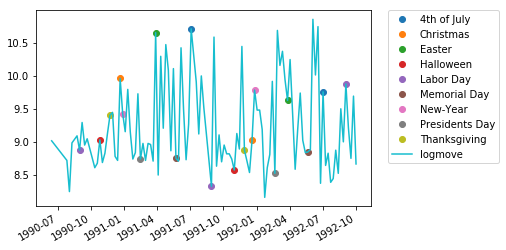

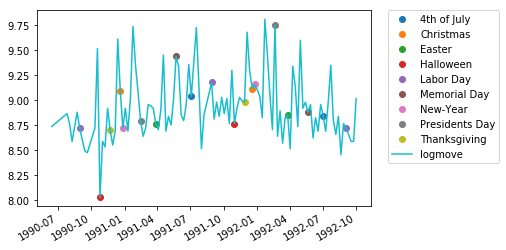

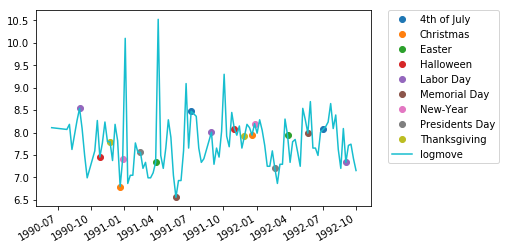

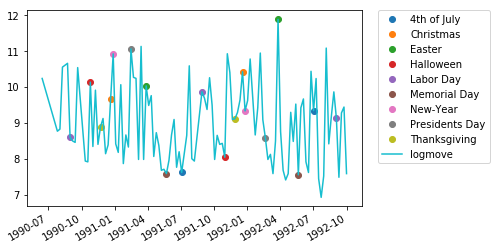

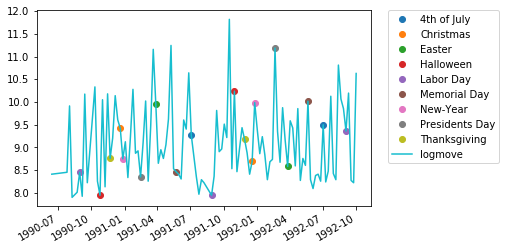

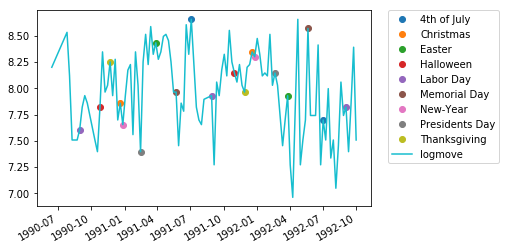

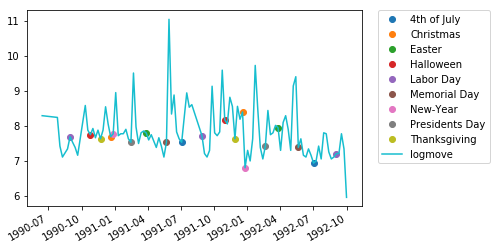

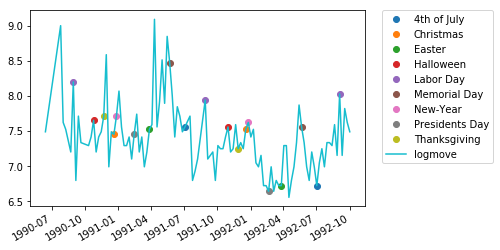

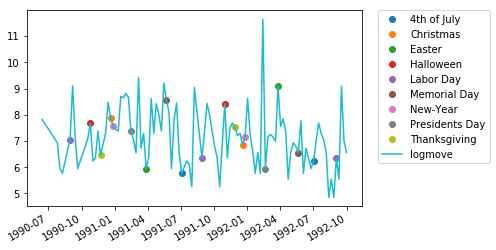

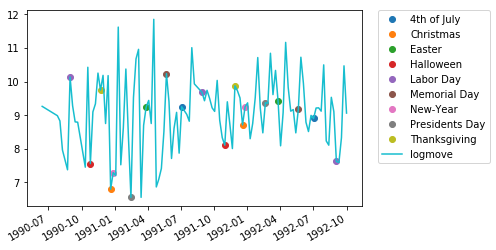

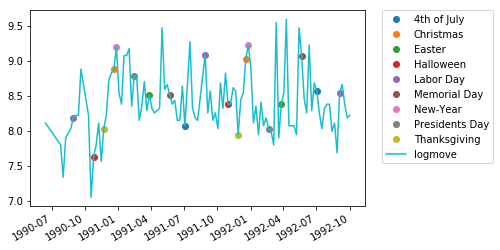

In [17]:
# plot the time series itself
# TODO: add holiday points
max_store_limit = 1
store_list = sales['store'].unique()
brand_list = sales['brand'].unique()
l_range = range(1, 53)

for i in range(min(max_store_limit, len(store_list))):
    for j in range(len(brand_list)):
        store = store_list[i]
        brand = brand_list[j]
        d = sales.loc[(sales['store'] == store) & (sales['brand'] == brand)]
        d_holiday = d.loc[d['Special Events'] != '']
        groups = d_holiday.groupby('Special Events')

        # Plot
        for name, group in groups:
            plt.plot(group['Start'], group['logmove'], 'o', label=name)
        plt.plot(d['Start'], d['logmove'])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.gcf().autofmt_xdate()
        plt.show()